# Logistic Regression Classifier Using Temporal Decoding
* analyzing eeg signals over time with temporal decoding. 

## Try classification with one run of one subject 
* It has been discovered that adding more data in the form of different runs of a subject and different subjects, into one classifier will severely diminish the results.
* Below I will classify one run of one subject to show that 

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#need this to create pipeline for classification
from sklearn.pipeline import make_pipeline
#for scaling data into n_sample * n_feature array
from sklearn.preprocessing import StandardScaler
#classifer
from sklearn.linear_model import LogisticRegression

import mne
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                         cross_val_multiscore, LinearModel, get_coef)

import os
import os.path as op

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

#data path for each run of each subject.
drive_data_path = 'E:\eeg_data'

#data path on my external hdd for folder containing all tests of each subject in one file
drive_all_data_path = 'E:\eeg_data\ica_140_500_0.1'

# plt.close('all')

### Temporal Decoding

In [4]:
epochs = mne.read_epochs(op.join(drive_data_path, 'Ex10_Suj1_Run1-epo.fif'),
                          preload=True);

Reading E:\eeg_data\Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [8]:
# Since roc_auc can only be computed for binary classifcation problems, data needs to be filtered 
# for two events.

epochs = epochs[(epochs.events[:,-1] == 4) | (epochs.events[:,-1] == 5)]

In [9]:
# get X and y parameters for classificaton
# X - samples in the form n_epochs, n_channels, n_times
X = epochs.get_data() 
# events or targets
y = epochs.events[:,-1]

In [10]:
clf = make_pipeline(StandardScaler(), LogisticRegression())

time_decod = SlidingEstimator(clf, n_jobs = 1, scoring = 'roc_auc')

scores = cross_val_multiscore(time_decod, X,y, cv = 5, n_jobs = 1)

In [11]:
scores = np.mean(scores, axis=0)

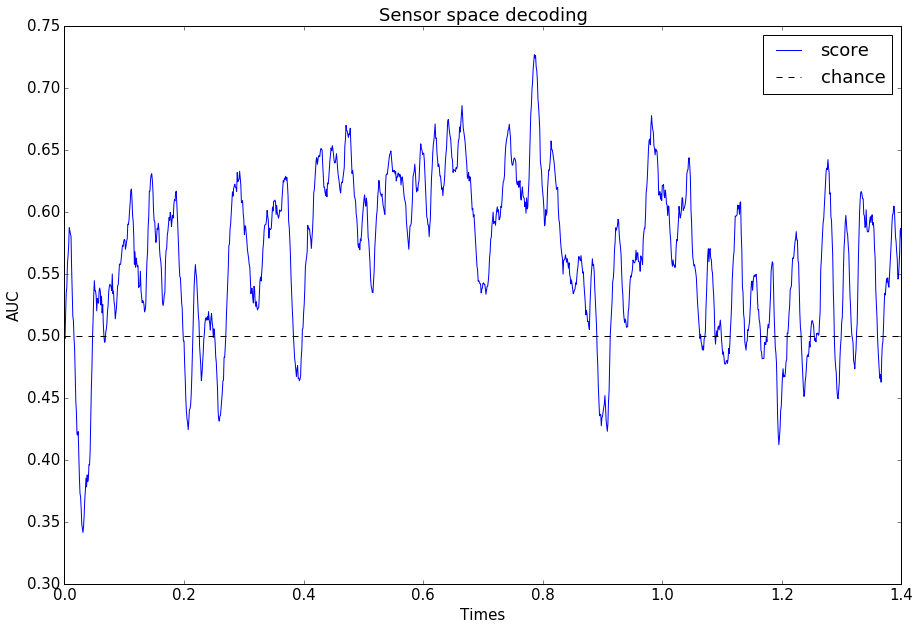

In [12]:
# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

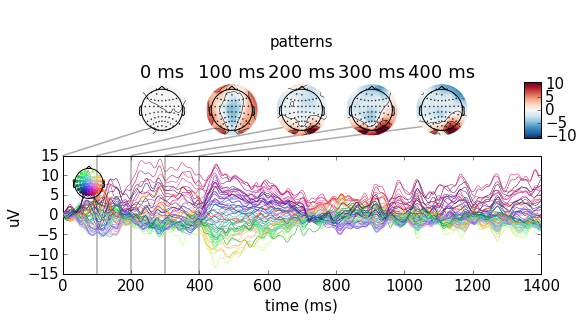

In [16]:
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression()))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
evoked.plot_joint(times=np.arange(0., .500, .100), title='patterns');